In [1]:
import os

from tqdm import tqdm
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer

In [2]:
df = pd.read_csv('scielo_dataset.csv', dtype={'ano': np.uint16})  # lendo o ano como um uint16 para economizar memória

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1672 non-null   object
 1   tipo             1665 non-null   object
 2   ano              1681 non-null   uint16
 3   doi_id           1661 non-null   object
 4   file_bruto_name  1681 non-null   object
dtypes: object(4), uint16(1)
memory usage: 55.9+ KB


Visualizando quais são os tipos dos textos

In [4]:
df['tipo'].value_counts()

artigos gerais                                                                          798
produtos e materiais didáticos                                                          202
pesquisa em ensino de física                                                            158
história da física e ciências afins                                                     145
desenvolvimento em ensino de física                                                      78
notas e discussões                                                                       61
cartas ao editor                                                                         28
seção especial: informática no ensino de física                                          19
editorial                                                                                17
seção especial                                                                           16
seção especial - celebrando os 100 anos de nascimento de richard p. feynman     

Criei essa lista com os tipos que se relacionam com ensino de ciências.

In [5]:
c = ['produtos e materiais didáticos', 'pesquisa em ensino de física', 'história da física e ciências afins',
     'desenvolvimento em ensino de física', 'seção especial: informática no ensino de física', 'história da física',
     'história da física e áreas afins', 'seção especial: encontro " reflexões no ensino de física", sbf/mec ( brasília, 2005)']

Escolhendo os itens que o tipo está contido lista e o ano é maior que 2014

In [6]:
edu_df = df.loc[(df['tipo'].isin(c)) & (df['ano'] > 2014)]  # Analisando de 2015 até 2022

In [7]:
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 50 to 808
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            323 non-null    object
 1   tipo             323 non-null    object
 2   ano              323 non-null    uint16
 3   doi_id           323 non-null    object
 4   file_bruto_name  323 non-null    object
dtypes: object(4), uint16(1)
memory usage: 13.2+ KB


In [8]:
arquivos = edu_df['file_bruto_name'].values  # pegando os arquivos

In [9]:
def limpa_html(text_html) -> str:
     soup = BeautifulSoup(text_html, 'lxml', parse_only=SoupStrainer('div', attrs={'data-anchor': 'Text'}))

     # tags do título, citações, referências, equações e figuras foram removidas.
     remover = soup.find_all('h1') + soup.find_all('span', attrs={'class': 'ref'}) + \
               soup.find_all('div', attrs={'class':'row formula'}) + soup.find_all('div', attrs={'class': 'row fig'}) + \
               soup.find_all('math')

     for tag in remover:
          tag.decompose()

     return ' '.join(soup.text.lower().split())

In [10]:
textos = []
for arq in tqdm(arquivos):
     path = os.path.abspath(os.path.join('artigos_brutos', arq))

     with open(path, 'r', encoding='utf8') as f:
          text = f.read()

     textos.append(limpa_html(text))

100%|██████████| 323/323 [00:23<00:00, 13.51it/s]


# Análise NLP

In [11]:
import spacy
nlp = spacy.load("pt_core_news_sm")

from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

In [69]:
my = {'p', 'fig', 'p.', 'cm', 'et', 'al', 't', 's', 'm', 'v', 'd', 'of', 'the', 'eq', 'figura', 'b', 'pi'}
stop = set(stopwords.words('portuguese')).union(STOP_WORDS).union(my)

In [117]:
# tokenização
documentos = []
for texto in tqdm(textos):
     doc = nlp(texto)
     documentos.append([token.lemma_ for token in doc if token.lemma_ not in stop and token.is_alpha])

100%|██████████| 323/323 [03:33<00:00,  1.51it/s]


In [118]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Adiciona bigrams e trigrams para os documentos (só se aparecer 5 vezes ou mais).
bigram = Phrases(documentos, min_count=5)
for idx in range(len(documentos)):
     for token in bigram[documentos[idx]]:
          if '_' in token:  # se for um n-gram, adiciona no documento
               documentos[idx].append(token)

# cria o dicionário
dictionary = Dictionary(documentos)

# Filtra as palabras que ocorrem em menos de 20 documentos ou mais que 60% dos documentos.
dictionary.filter_extremes(no_below=10, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in documentos]

# Train LDA model.
# Set training parameters.
num_topics = 12
chunksize = 400
passes = 50
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [119]:
medias = {}
for n in tqdm(range(10,21)):
     model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=n,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )
     cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
     
     medias[n] = cm_u_mass.get_coherence()

100%|██████████| 11/11 [09:09<00:00, 49.92s/it]


In [120]:
print(medias)

{10: -0.8491334773169685, 11: -0.858679565195838, 12: -0.920492154262273, 13: -0.9133333615416539, 14: -0.9682025242906429, 15: -1.0083208967367667, 16: -0.9339091156330673, 17: -0.9803571757065636, 18: -1.044112154473843, 19: -0.9991654009540748, 20: -1.0096338608888416}


In [121]:
import matplotlib.pyplot as plt

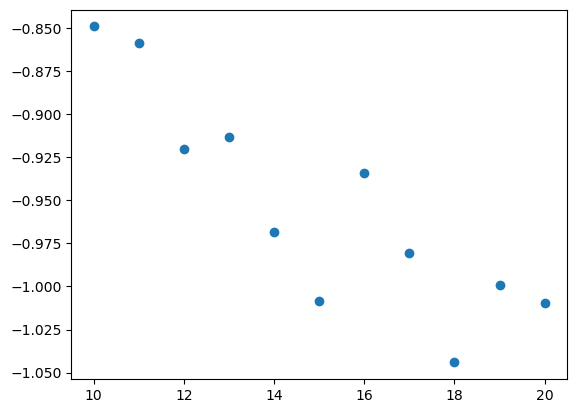

In [122]:
plt.scatter(medias.keys(), medias.values())